**Setup**

In [37]:
import geopandas as gpd

linkGit='https://github.com/DACSS-Spatial/data_forSpatial/raw/refs/heads/main/'
linkWorldMaps='WORLD/worldMaps.gpkg'

countries=gpd.read_file(linkGit+linkWorldMaps,layer='countries')

countries

import pandas as pd

someDataLink='WORLD/some_dataworld.csv'

someData=pd.read_csv(linkGit+someDataLink)

linkToIndicators="https://github.com/DACSS-Spatial/data_forSpatial/raw/refs/heads/main/WORLD/worldindicators.json"
theMapAndData=gpd.read_file(linkToIndicators)


**Dot Density Map**

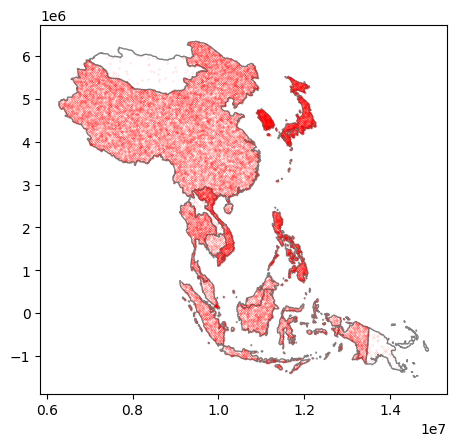

In [38]:
e_se_asia=theMapAndData[theMapAndData.region=='EAST AND SOUTHEAST ASIA']

(e_se_asia.set_index("Country").mobiles / 100000).astype(int).sort_values()

temporal_gdf=e_se_asia.copy()

temporal_gdf.set_index('Country',inplace=True)

temporal_gdf['dots_per_country'] = (e_se_asia['mobiles'] / 100000).astype(int).values

temporal_gdf.sample_points(size=temporal_gdf['dots_per_country'],rng=123).loc['CHINA']

e_se_asia_dots=gpd.GeoDataFrame(geometry=temporal_gdf.sample_points(size=temporal_gdf['dots_per_country'],rng=123))

e_se_asia_8857 = e_se_asia.to_crs(8857)
e_se_asia_dots_8857 = e_se_asia_dots.to_crs(8857)

base=e_se_asia_8857.plot(facecolor="white",
               edgecolor='grey')
e_se_asia_dots_8857.plot(markersize=0.01, color='red',ax=base, alpha=0.7)

e_se_asia_dots_8857 = e_se_asia_dots_8857.explode(ignore_index=True)

**Proportional Symbols Map**

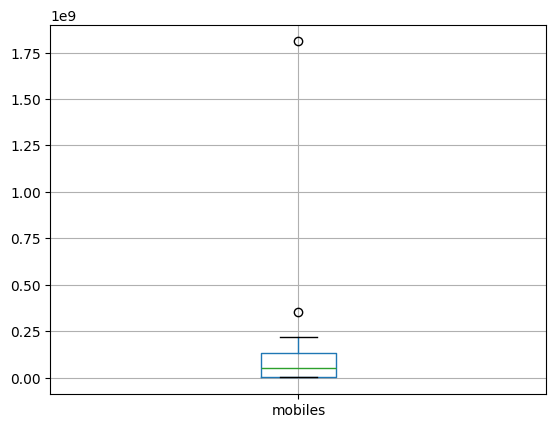

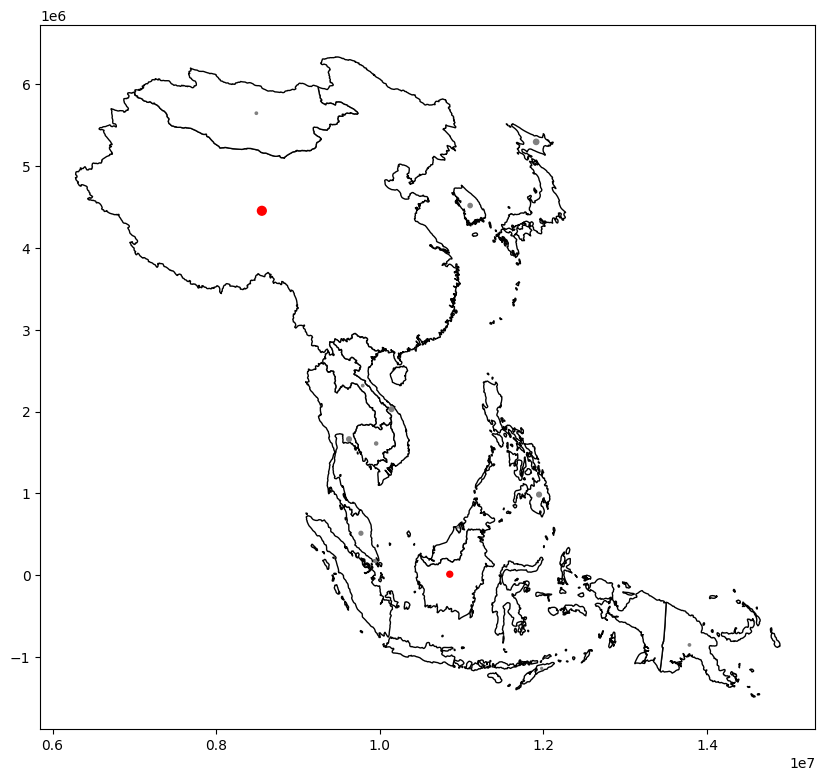

In [39]:
import numpy as np

max_size=40
min_size=1
scaled_sizes = np.sqrt(
    (e_se_asia_8857.mobiles - e_se_asia_8857.mobiles.min()) / (e_se_asia_8857.mobiles.max() - e_se_asia_8857.mobiles.min())
) * (max_size-1) + min_size

scaled_sizes.sort_values()

e_se_asia_8857_symbols = e_se_asia_8857.copy()
e_se_asia_8857_symbols.set_index('Country',inplace=True)

e_se_asia_8857_symbols['size']=scaled_sizes.values

e_se_asia_8857_symbols['geometry'] = e_se_asia_8857.representative_point().values
'''
base = e_se_asia_8857.plot(facecolor="white",
                      edgecolor='grey')
e_se_asia_8857_symbols.plot(
    ax=base,
    markersize=e_se_asia_8857_symbols['size'],
    color='black'
)
'''
boxplotInfo=e_se_asia_8857_symbols.boxplot(column='mobiles',return_type="dict")

outliers=boxplotInfo['fliers'][0].get_ydata()

e_se_asia_8857_symbols[e_se_asia_8857_symbols.mobiles.isin(outliers)].index

e_se_asia_8857_symbols['mobiles_outlier']=e_se_asia_8857_symbols.mobiles.isin(outliers)*1

base = e_se_asia_8857.plot(color='white', edgecolor='black', figsize=(10,10))

mapcolor = {1: 'red', 0: 'grey'}

e_se_asia_8857_symbols.plot(
    ax=base,
    markersize=e_se_asia_8857_symbols['size'],
    color=e_se_asia_8857_symbols['mobiles_outlier'].map(mapcolor)
)

#export
e_se_asia_8857_symbols.reset_index(drop=False, inplace=True)
e_se_asia_8857_symbols.drop(columns=['iso2', 'region', 'fragility', 'co2', 'sq_km', 'num_airports','population'], inplace=True)

**Choropleth**

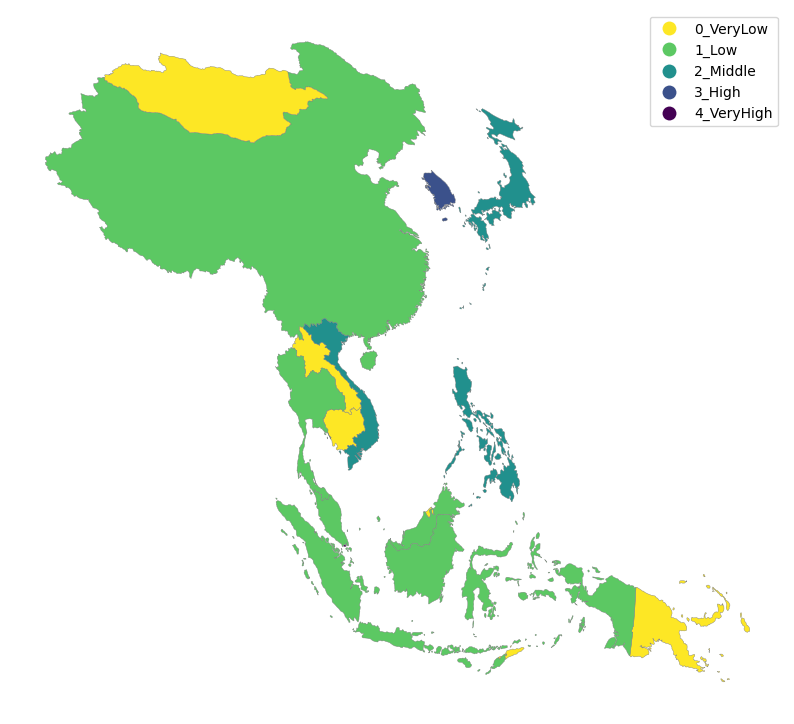

In [40]:
import mapclassify
import numpy as np

e_se_asia_8857['mobiles_density']=e_se_asia_8857.mobiles/e_se_asia_8857.sq_km

np.random.seed(12345)

K=5
theVar=e_se_asia_8857['mobiles_density']

# same interval width, easy interpretation
ei5 = mapclassify.EqualInterval(theVar, k=K)
# same interval width based on standard deviation, easy - but not as the previous one, poor when high skewness
msd = mapclassify.StdMean(theVar)
# interval width varies, counts per interval are close, not easy to grasp, repeated values complicate cuts
q5=mapclassify.Quantiles(theVar,k=K)

# based on similarity, good for multimodal data
mb5 = mapclassify.MaximumBreaks(theVar, k=K)
# based on similarity, good for skewed data
ht = mapclassify.HeadTailBreaks(theVar) # no K needed
# based on similarity, optimizer
fj5 = mapclassify.FisherJenks(theVar, k=K)
# based on similarity, optimizer
jc5 = mapclassify.JenksCaspall(theVar, k=K)
# based on similarity, optimizer
mp5 = mapclassify.MaxP(theVar, k=K)

class5 = ei5,msd, q5,mb5,  ht, fj5, jc5, mp5
# Collect ADCM for each classifier
fits = np.array([ c.adcm for c in class5])
# Convert ADCM scores to a DataFrame
adcms = pd.DataFrame(fits)
# Add classifier names
adcms['classifier'] = [c.name for c in class5]
# Add column names to the ADCM
adcms.columns = ['ADCM', 'Classifier']
'''
adcms.sort_values('ADCM').plot.barh(x='Classifier')
'''
e_se_asia_8857['mobiles_density_FJ5'] = fj5.yb

e_se_asia_8857[['mobiles_density','mobiles_density_FJ5']].head(20)

newLabelsForLevels={0:"0_VeryLow", 1:"1_Low", 2:"2_Middle", 3:"3_High", 4:"4_VeryHigh"}

e_se_asia_8857['mobiles_density_FJ5_cat']=e_se_asia_8857.loc[:,'mobiles_density_FJ5'].replace(newLabelsForLevels)

e_se_asia_8857[['mobiles_density','mobiles_density_FJ5','mobiles_density_FJ5_cat']].head(20)

import matplotlib.pyplot as plt

f, ax = plt.subplots(1, figsize=(10, 10))
e_se_asia_8857.plot(column='mobiles_density_FJ5_cat',
                 cmap='viridis_r',
                 categorical=True,
                 edgecolor='grey',
                 linewidth=0.3,
                 legend=True,
                 ax=ax
       )

ax.set_axis_off()

geodataframe_list = [var for var in globals() if isinstance(globals()[var], gpd.GeoDataFrame)]

'''
print("List of GeoDataFrames in memory:")
for name in geodataframe_list:
    print(name)
'''

e_se_asia_8857.to_file("e_se_asia_8857.gpkg",driver='GPKG',layer='continent')
e_se_asia_dots_8857.to_file("e_se_asia_8857.gpkg",driver='GPKG',layer='mobiles_ddm')
e_se_asia_8857_symbols.to_file("e_se_asia_8857.gpkg",driver='GPKG',layer='mobiles_psm')

In [41]:
!pip install mapclassify